In [1]:
import os
import cv2
import numpy as np
from skimage import feature
import random
import matplotlib.pyplot as plt

In [2]:
def quantify_image(image):
    features = feature.hog(image, orientations=9,
                           pixels_per_cell=(10, 10), cells_per_block=(2, 2),
                           transform_sqrt=True, block_norm="L1")
    return features

In [3]:
def load_split(path):
    # grab the list of images in the input directory, then initialize
    # the list of data (i.e., images) and class labels
    imagePaths = list(paths.list_images(path))
    data = []
    labels = []
    # loop over the image paths
    for imagePath in imagePaths:
        # extract the class label from the filename
        label = imagePath.split(os.path.sep)[-2]
        # load the input image, convert it to grayscale, and resize
        # it to 200x200 pixels, ignoring aspect ratio
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        # threshold the image such that the drawing appears as white
        # on a black background
        image = cv2.threshold(image, 0, 255,
                              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        # quantify the image
        features = quantify_image(image)
        # update the data and labels lists, respectively
        data.append(features)
        labels.append(label)
    return (np.array(data), np.array(labels))

In [4]:
!pip install imutils

In [5]:
from imutils import paths
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

In [6]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_38694fa4a4894167ba87740cae0c5d51 = 'https://s3.us.cloud-object-storage.appdomain.cloud'
else:
    endpoint_38694fa4a4894167ba87740cae0c5d51 = 'https://s3.private.us.cloud-object-storage.appdomain.cloud'

client_38694fa4a4894167ba87740cae0c5d51 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='1TRwL1rNygjDskXgRafq4oU8ZVu3KJSPfE3FH2D630W6',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_38694fa4a4894167ba87740cae0c5d51)

streaming_body_2 = client_38694fa4a4894167ba87740cae0c5d51.get_object(Bucket='parkinsondiseasedetection-donotdelete-pr-jfpxgnia1mag9g', Key='spiral_ds.zip')['Body']

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/


In [7]:
from io import BytesIO
import zipfile
unzip=zipfile.ZipFile(BytesIO(streaming_body_2.read()),'r')
file_paths=unzip.namelist()
for path in file_paths:
    unzip.extract(path)

In [8]:
import os
filename=os.listdir('/home/wsuser/work/spiral/training')

In [9]:
! pip install keras==2.2.4

In [10]:
def train_model(dataset):
    path = "/home/wsuser/work/" + dataset
    trainingPath = os.path.sep.join([path, "training"])
    testingPath = os.path.sep.join([path, "testing"])
    # load the data
    (trainX, trainY) = load_split(trainingPath)
    (testX, testY) = load_split(testingPath)
    # encode the labels
    le = LabelEncoder()
    trainY = le.fit_transform(trainY)
    testY = le.transform(testY)
    model=RandomForestClassifier(n_estimators=100)
    model=model.fit(trainX, trainY)
    pickle.dump(model,open('model.pkl','wb')) 
    predictions = model.predict(testX)
    cm = confusion_matrix(testY, predictions).ravel()
    tn, fp, fn, tp = cm
    accuracy = (tp + tn) / float(cm.sum())
    sensitivity= tp / float(tp + fn)
    specificity = tn / float(tn + fp)
    print(accuracy)
    print(sensitivity)
    print(specificity)
    return model

In [14]:
import pickle

In [15]:
spiralModels = train_model('spiral')

0.7666666666666667
0.6666666666666666
0.8666666666666667


In [16]:
def test_prediction(model, testingPath):
    # get the list of images
    testingPaths = list(paths.list_images(testingPath))
    output_images = []
    # pick 15 images at random
    for _ in range(15):
        image = cv2.imread(random.choice(testingPaths))
        output = image.copy()
        output = cv2.resize(output, (128, 128))
        # pre-process the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        image = cv2.threshold(image, 0, 255,
                              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        # quantify the image and make predictions based on the extracted features
        features = quantify_image(image)
        preds = model.predict([features])
        label = "Parkinsons" if preds[0] else "Healthy"

        # draw the colored class label on the output image and add it to
        # the set of output images
        color = (0, 255, 0) if label == "Healthy" else (0, 0, 255)
        cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    color, 2)
        output_images.append(output)
    plt.figure(figsize=(20, 20))
    for i in range(len(output_images)):
        plt.subplot(5, 5, i+1)
        plt.imshow(output_images[i])
        plt.axis("off")
    plt.show()

In [17]:
!pip install watson-machine-learning-client --upgrade


     |████████████████████████████████| 538 kB 25.9 MB/s eta 0:00:01


In [18]:
import pickle

In [19]:
!tar -zcvf Parkinson_Disease_Detection_model.tgz model.pkl

model.pkl


In [20]:
ls -1

model.pkl
Parkinson_Disease_Detection_model.tgz
spiral/


In [21]:
!pip install --upgrade "ibm-watson>=5.2.3"

In [22]:
from ibm_watson_machine_learning import APIClient
wml_credentials={"url":"https://us-south.ml.cloud.ibm.com", "apikey": "OC8p_bUhUrB691-qz0eOiXi1xRFH8VoAaOwjW3z4GXcF"}
client=APIClient(wml_credentials)

In [24]:
def guide_from_space_name(client,space_name):
    space=client.spaces.get_details()
    return(next(item for item in space['resources']if item['entity']["name"]==space_name)['metadata']['id'])

In [25]:
space_uid=guide_from_space_name(client,'Parkinson_deploy')
print("Space UID =" + space_uid)

Space UID =67b2e421-1056-49a4-a026-04407a41091b


In [26]:
client.set.default_space(space_uid)

'SUCCESS'

In [27]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
scikit-learn_0.22-py3.6        154010fa-5b3b-4ac1-82af-4d5ee5abbc85  base
default_r3.6                   1b70aec3-ab34-4b87-8aa0-a4a3c8296a36  base
pytorch-onnx_1.3-py3.6         1bc6029

In [28]:
software_spec_uid=client.software_specifications.get_uid_by_name("default_py3.8")
software_spec_uid

'ab9e1b80-f2ce-592c-a7d2-4f2344f77194'

In [29]:
!pip install watson-machine-learning-client


In [30]:
model_details=client.repository.store_model(model='Parkinson_Disease_Detection_model.tgz',meta_props={client.repository.ModelMetaNames.NAME:"parkinson_model",client.repository.ModelMetaNames.TYPE:"scikit-learn_0.23",client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_spec_uid})
model_id=client.repository.get_model_uid(model_details)

In [31]:
model_id

'6017fe82-ebd6-4367-a856-46322224c3e9'

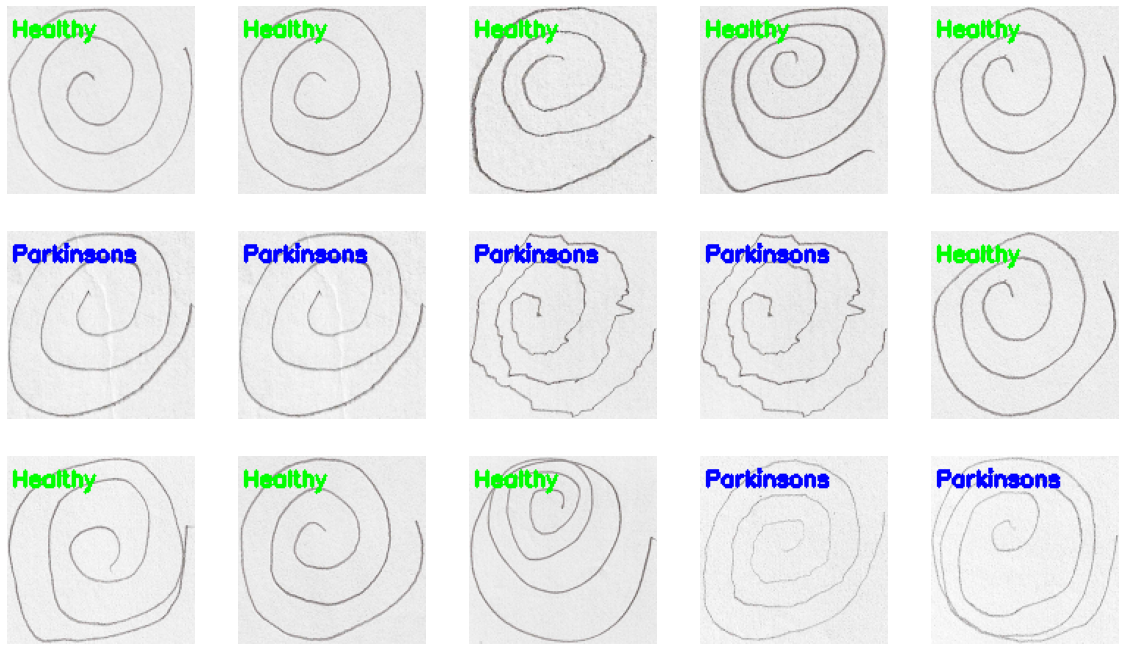

In [32]:
testingPath = os.path.sep.join(["/home/wsuser/work/spiral", "testing"])
test_prediction(spiralModels, testingPath)